In [2]:
def limitCheck(value):
    if(value < 0 or value >= 288):
        return 0
    else:
        return 1

In [3]:
#load data (displacement and images)
import os
import cv2
import numpy as np
import pandas as pd

#load bead images
cell = "Cell_6"
dataDir = f"/home/local2/FTTC/Code/Traction_LSTM/Trial_4/{cell}"
windowSize = 16
halfWindowSize = windowSize // 2
centerDistance = 8
windows = []
diffWindows = []
displacements = []

for folderName in sorted(os.listdir(dataDir)):
    # print(f"Processing folder: {folderName}")
    folderPath = os.path.join(dataDir, folderName)
    if not os.path.isdir(folderPath):
        continue
    # if(folderPath!="/home/local2/FTTC/Code/Traction_LSTM/Trial_4/Cell_6/Cell1"):
    #     continue
    beadRefFile = os.path.join(folderPath, "cropCell200002.bmp.tif")
    beadDeformedFile = os.path.join(folderPath, "cropCell200001.bmp.tif")
    displacementFile = os.path.join(folderPath, "displacement.csv")

    brdata = cv2.imread(beadRefFile, cv2.IMREAD_GRAYSCALE)
    bddata = cv2.imread(beadDeformedFile, cv2.IMREAD_GRAYSCALE)
    dispData = pd.read_csv(displacementFile, header=None)
    # print(dispData.columns)
    # print(dispData.shape)


    counter = 0
    # split the images into windows
    for row in range(0, 288, centerDistance):
        for col in range(0, 288, centerDistance):
            brwindow = np.zeros((windowSize, windowSize))
            bdwindow = np.zeros((windowSize, windowSize))
            # fetch the window data from brdata
            for i in range(windowSize):
                for j in range(windowSize):
                    if(limitCheck(row - halfWindowSize + i) and limitCheck(col - halfWindowSize + j)):
                        brwindow[i, j] = brdata[row - halfWindowSize + i, col - halfWindowSize + j]
                        bdwindow[i, j] = bddata[row - halfWindowSize + i, col - halfWindowSize + j]
                    else:
                        brwindow[i, j] = 0
                        bdwindow[i, j] = 0    
            
            # add the window to the list                       
            windows.append([brwindow, bdwindow, bdwindow - brwindow])
            displacements.append([dispData[0][counter], dispData[1][counter]])
            counter += 1

    # print(f"Number of windows: {len(windows)}")
    
windows_array = np.array(windows)
windows_array = np.rollaxis(windows_array, 1, 4)
displacements_array = np.array(displacements)
print(f"windows_array shape: {windows_array.shape}")
print(f"displacements_array shape: {displacements_array.shape}")
  
print("Done!")                     

windows_array shape: (381024, 16, 16, 3)
displacements_array shape: (381024, 2)
Done!


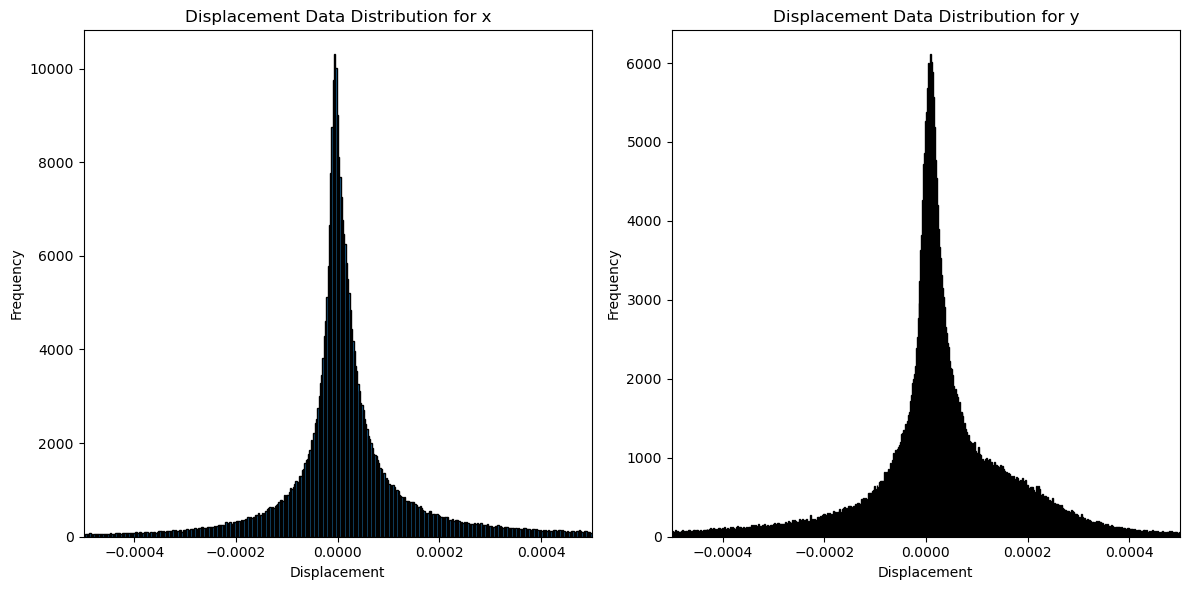

In [4]:
import matplotlib.pyplot as plt

# Create histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # first subplot
plt.hist(displacements_array[:, 0], bins=100000, edgecolor='black')
plt.title('Displacement Data Distribution for x')
plt.xlabel('Displacement')
plt.ylabel('Frequency')
# plt.xlim(-1,1)
plt.xlim(-0.0005,0.0005)

plt.subplot(1, 2, 2)  # second subplot
plt.hist(displacements_array[:, 1], bins=100000, edgecolor='black')
plt.title('Displacement Data Distribution for y')
plt.xlabel('Displacement')
plt.ylabel('Frequency')
plt.xlim(-0.0005,0.0005)

# Show the plots
plt.tight_layout()
plt.show()

In [17]:

# modified_disp = np.clip(np.abs(displacements_array), 0, 0.5)

# # print mean and std of displacements
# print(f"Mean of displacements in x: {np.mean(modified_disp[:, 0])}")
# print(f"Mean of displacements in y: {np.mean(modified_disp[:, 1])}")
# print(f"Std of displacements in x: {np.std(modified_disp[:, 0])}")
# print(f"Std of displacements in y: {np.std(modified_disp[:, 1])}")

Mean of displacements in x: 1.4577681196186104e-08
Mean of displacements in y: -1.2356963971134475e-08
Std of displacements in x: 0.6527945863607406
Std of displacements in y: 0.6519167506542162


In [5]:
#normalize data using min max normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
displacements_array_org_shape = displacements_array.shape
windows_array_org_shape = windows_array.shape

displacements_array_norm = scaler.fit_transform(displacements_array.reshape(-1, 1)).reshape(displacements_array_org_shape)
windows_array_norm = scaler.fit_transform(windows_array.reshape(-1, 1)).reshape(windows_array_org_shape)

print("shape of displacements_array_normalized: ", displacements_array_norm.shape)
print("shape of windows_array_normalized: ", windows_array_norm.shape)

shape of displacements_array_normalized:  (95256, 2)
shape of windows_array_normalized:  (95256, 32, 32, 3)


In [5]:

# Define your range
lower_bound = -0.0005#-0.2
upper_bound = 0.0005 #0.2

# Create a boolean mask for the displacements in the desired range
mask = (displacements_array[:, 0] >= lower_bound) & (displacements_array[:, 0] <= upper_bound)

# Apply the mask to the displacements and windows
filtered_displacements = displacements_array[mask]
filtered_windows = windows_array[mask]

print(f"filtered_displacements shape: {filtered_displacements.shape}")
print(f"filtered_windows shape: {filtered_windows.shape}")

filtered_displacements shape: (354199, 2)
filtered_windows shape: (354199, 16, 16, 3)


In [7]:
# #create training and testing data

# train_windows =filtered_windows[:30000] #60000
# val_windows = filtered_windows[30000:]
# train_displacements = filtered_displacements[:30000]
# val_displacements =  filtered_displacements[30000:]

In [6]:
#create training and testing data
from sklearn.model_selection import train_test_split

# train_windows = windows_array[:75000]
# val_windows = windows_array[75000:]
# train_displacements = displacements_array[:75000]
# val_displacements =  displacements_array[75000:]

train_windows, val_windows, train_displacements, val_displacements = train_test_split(filtered_windows, filtered_displacements, test_size=0.2, random_state=42)

print(f"train_windows shape: {train_windows.shape}")
print(f"val_windows shape: {val_windows.shape}")
print(f"train_displacements shape: {train_displacements.shape}")
print(f"val_displacements shape: {val_displacements.shape}")


train_windows shape: (283359, 16, 16, 3)
val_windows shape: (70840, 16, 16, 3)
train_displacements shape: (283359, 2)
val_displacements shape: (70840, 2)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# use strategy
strategy = tf.distribute.MirroredStrategy()

#create model
# Create the CNN model
with strategy.scope():
    model = Sequential()
    model.add(Conv2D(4, (3, 3), activation='relu', input_shape=(windowSize, windowSize,3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(10))
    model.add(Dense(2))  # Output layer with 2 units for x and y displacements


    # Compile the model
    optim = Adam(learning_rate=0.00001)
    model.compile(optimizer=optim, loss='mean_squared_error')

    # Train the model
    modelDetails = model.fit(train_windows, train_displacements, validation_data=(val_windows, val_displacements), epochs=4, verbose=1)

# Save the model
model.save("./beadDisplacementPred_model.h5")


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/4


2024-04-10 15:09:58.559673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [283359,2]
	 [[{{node Placeholder/_11}}]]
2024-04-10 15:09:58.560138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [283359,2]
	 [[{{node Placeholder/_11}}]]
2024-04-10 15:09:58.713329: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-04-10 15:09:58.713888: I tensorflow/core/common_runtime/executor

8855/8855 [==============================] - ETA: 0s - loss: 0.5072

2024-04-10 15:37:59.983455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [70840,2]
	 [[{{node Placeholder/_11}}]]
2024-04-10 15:37:59.983869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [70840,2]
	 [[{{node Placeholder/_11}}]]
2024-04-10 15:38:00.071327: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-04-10 15:38:00.071749: I tensorflow/core/common_runtime/executor.c

8855/8855 [==============================] - 1702s 192ms/step - loss: 0.5072 - val_loss: 0.0194
Epoch 2/4
2628/8855 [=======>......................] - ETA: 20:38 - loss: 0.0113

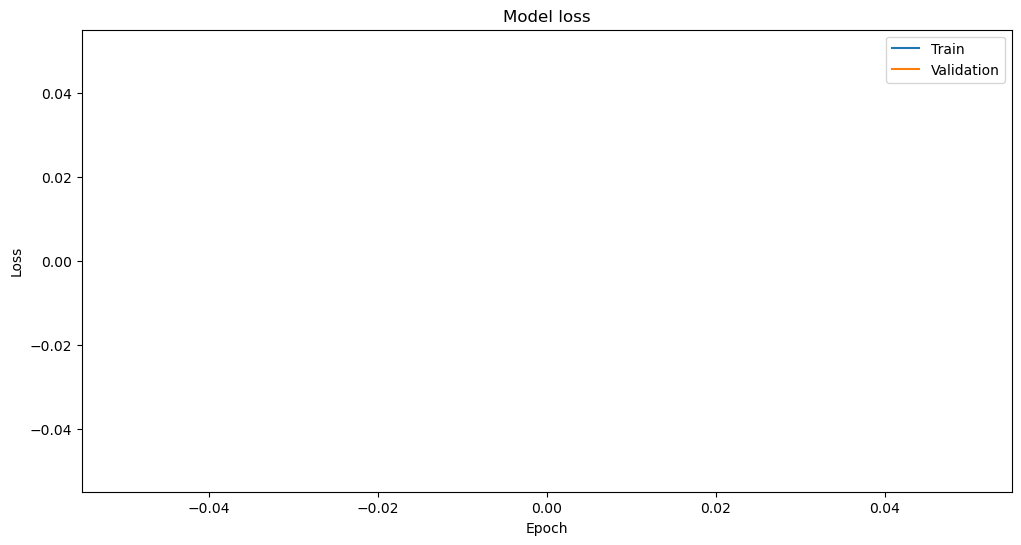

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(np.log(modelDetails.history['loss'][10:]))
plt.plot(np.log(modelDetails.history['val_loss'][10:]))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
# Save the figure
plt.savefig('model_loss.png', dpi=300)
plt.show()

2214/2214 [==============================] - 19s 8ms/step
Actual: [-6.7577e-05  2.1740e-04], Predicted: [-6.0504099e-05  1.5729041e-04], Error: [-7.07290134e-06  6.01095852e-05] error rate: [10.46643288 27.64930322]
Actual: [-0.00025041 -0.00045639], Predicted: [-6.0504099e-05  1.5729041e-04], Error: [-0.00018991 -0.00061368] error rate: [ 75.83798624 134.4640362 ]
Actual: [-2.0917e-05  8.1972e-05], Predicted: [-6.0504099e-05  1.5729041e-04], Error: [ 3.95870987e-05 -7.53184148e-05] error rate: [-189.25801337  -91.88310007]
Actual: [-3.1434e-06  9.8419e-06], Predicted: [-6.0504099e-05  1.5729041e-04], Error: [ 5.73606987e-05 -1.47448515e-04] error rate: [-1824.79794667 -1498.17123513]
Actual: [-2.1611e-05  3.0500e-05], Predicted: [-6.0504099e-05  1.5729041e-04], Error: [ 3.88930987e-05 -1.26790415e-04] error rate: [-179.96899105 -415.706278  ]
Actual: [-5.6411e-05  1.7983e-03], Predicted: [-6.0504099e-05  1.5729041e-04], Error: [4.09309866e-06 1.64100959e-03] error rate: [-7.25585197 9

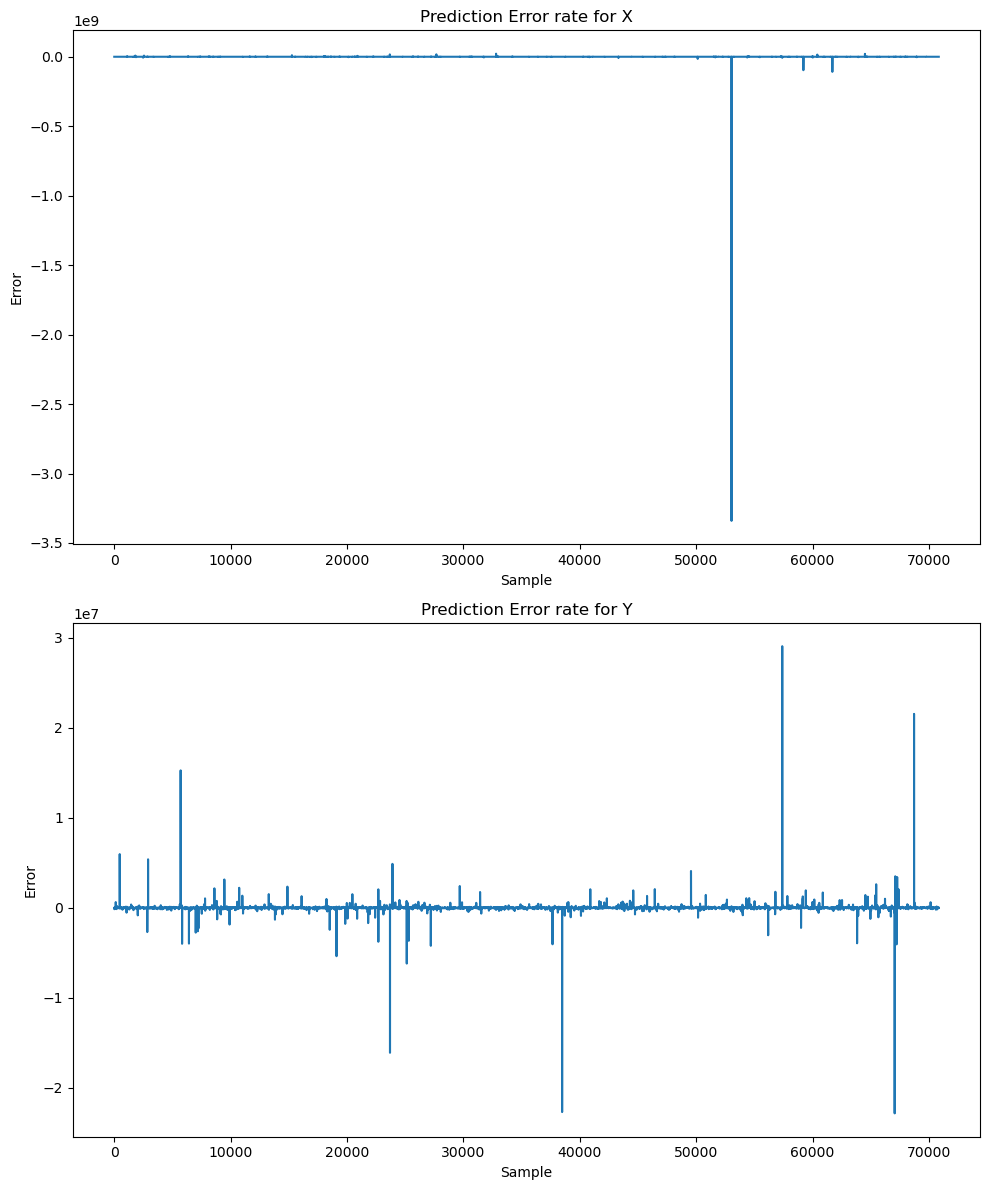

RMSE: 0.0024981295539904793


In [7]:
import matplotlib.pyplot as plt
# Load the model
loadedModel = load_model("./beadDisplacementPred_model.h5")

# Predict the displacements using the trained model
val_predictions = loadedModel.predict(val_windows)

# Calculate the errors
errors = val_displacements - val_predictions


errors_rate = (errors / val_displacements) * 100

for i in range(0, 20):
    print(f"Actual: {val_displacements[i]}, Predicted: {val_predictions[i]}, Error: {errors[i]} error rate: {errors_rate[i]}")


error_x = errors_rate[:, 0]
error_y = errors_rate[:, 1]


# Calculate the average error rate
average_error_rate = np.mean(np.abs(errors))

print("Average error rate: ", average_error_rate)

# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 12))

# Plot error_x
axs[0].plot(error_x)
axs[0].set_title('Prediction Error rate for X')
axs[0].set_xlabel('Sample')
axs[0].set_ylabel('Error')

# Plot error_y
axs[1].plot(error_y)
axs[1].set_title('Prediction Error rate for Y')
axs[1].set_xlabel('Sample')
axs[1].set_ylabel('Error')

# Display the plots
plt.tight_layout()
plt.show()

# Calculate the RMSE
rmse = mean_squared_error(val_displacements, val_predictions, squared=False)
print(f"RMSE: {rmse}")